In [ ]:
# !pip install scipy

In [2]:
from scipy.io import loadmat

loaded_dataset = loadmat("dataset_liver_bmodes_steatosis_assessment_IJCARS.mat")

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

In [4]:
images = loaded_dataset["data"]["images"][0][0]

In [5]:
def enhancer_image(image):
    image = np.uint8(image)
    scaled_image = (image / np.max(image)) * 255
    scaled_image = scaled_image.astype(np.uint8)

    # Apply adaptive histogram equalization (CLAHE) to enhance local contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(scaled_image.astype(np.uint8))

    # Apply bilateral filtering for noise reduction while preserving edges
    enhanced_image = cv2.bilateralFilter(enhanced_image, 15, 50, 50)

    # Apply sharpening using the Laplacian filter
    laplacian = cv2.Laplacian(enhanced_image, cv2.CV_64F)
    sharpened_image = np.uint8(np.clip(enhanced_image - 0.5 * laplacian, 0, 255))
    normalized_image = cv2.normalize(
        sharpened_image,
        None,
        alpha=0,
        beta=1,
        norm_type=cv2.NORM_MINMAX,
        dtype=cv2.CV_32F,
    )

    return normalized_image

In [31]:
def enhancerest_image(image):
    image = np.uint8(image)

    image = cv2.resize(image, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

    scaled_image = (image / np.max(image)) * 255
    scaled_image = scaled_image.astype(np.uint8)

    # Apply adaptive histogram equalization (CLAHE) to enhance local contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(scaled_image.astype(np.uint8))

    # Apply bilateral filtering for noise reduction while preserving edges
    enhanced_image = cv2.bilateralFilter(enhanced_image, 15, 50, 50)

    # Apply sharpening using the Laplacian filter
    laplacian = cv2.Laplacian(enhanced_image, cv2.CV_64F)
    sharpened_image = np.uint8(np.clip(enhanced_image - 0.5 * laplacian, 0, 255))
    normalized_image = cv2.normalize(
        sharpened_image,
        None,
        alpha=0,
        beta=1,
        norm_type=cv2.NORM_MINMAX,
        dtype=cv2.CV_32F,
    )

    return normalized_image

In [6]:
def show_img(label, image):
    # image = image.astype(np.uint8)

    cv2.imshow(label, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [32]:
data = loaded_dataset["data"]
data_records = {"id": [], "fat": [], "class": [], "images": []}

for record in range(55):
    id_ = data["id"][0][record][0][0]
    fat = data["fat"][0][record][0][0]
    cat = data["class"][0][record][0][0]
    imgs = data["images"][0][record]

    for index, im in enumerate(imgs):
        filename = f"{id_}_{cat}_{fat}_{index}.jpg"
        # enh_im = enhance_image(im.astype(np.uint8))
        enh_im1 = enhancerest_image(im.astype(np.uint8))

        # cropping the image for region of interest
        roi_im = enh_im1[120:350, 125:420]

        # to save images:
        # plt.imsave(f"og/{filename}", im.astype(np.uint8),cmap="grey" )
        # plt.imsave(f"enh/{filename}", enh_im, cmap="grey" )
        # plt.imsave(f"roi/{filename}", roi_im, cmap="grey")
        roi_im = roi_im.astype(np.uint8)

        data_records["id"].append(id_)
        data_records["fat"].append(fat)
        data_records["class"].append(cat)
        data_records["images"].append(roi_im)

df = pd.DataFrame(data_records)

In [33]:
df

,id,fat,class,images
0,1,3,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,1,3,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,1,3,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,1,3,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,1,3,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...
545,55,20,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
546,55,20,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
547,55,20,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
548,55,20,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [56]:
df["images"][0].shape

(230, 295)

In [34]:
from skimage.feature import graycomatrix, graycoprops


# Define function to compute GLCM features for a single image
def compute_glcm_features(image):
    distances = [1, 2, 3]  # Define distances for GLCM computation
    angles = [
        0,
        np.pi / 4,
        np.pi / 2,
        3 * np.pi / 4,
    ]  # Define angles for GLCM computation
    glcm = graycomatrix(
        image, distances=distances, angles=angles, symmetric=True, normed=True
    )

    # Compute GLCM properties
    contrast = graycoprops(glcm, "contrast").ravel()
    energy = graycoprops(glcm, "energy").ravel()
    homogeneity = graycoprops(glcm, "homogeneity").ravel()
    correlation = graycoprops(glcm, "correlation").ravel()

    # Concatenate GLCM features
    glcm_features = np.concatenate([contrast, energy, homogeneity, correlation])
    return glcm_features

In [35]:
df["images"]

0      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
1      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
4      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
                             ...                        
545    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
546    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
547    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
548    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
549    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
Name: images, Length: 550, dtype: object

In [36]:
images = df["images"].values

# Compute GLCM features for each image
glcm_features = [compute_glcm_features(image) for image in images]

# Concatenate GLCM features into a feature matrix
feature_matrix = np.array(glcm_features)

In [37]:
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define the number of folds for cross-validation
num_folds = 7

# Initialize a KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize a PCA object
pca = PCA(n_components=11)

# Initialize a Support Vector Machine classifier
clf = SVC()
# Initialize an array to store accuracy scores
accuracy_scores = []
y = df[["class"]]

# Perform cross-validation
for train_index, test_index in kf.split(feature_matrix):
    X_train, X_test = feature_matrix[train_index], feature_matrix[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply PCA to the training and test data
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Train the classifier
    clf.fit(X_train_pca, y_train)

    # Make predictions
    y_pred = clf.predict(X_test_pca)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

# Calculate the mean accuracy score across all folds
mean_accuracy = np.mean(accuracy_scores)
print("Mean Accuracy:", mean_accuracy)

c:\Users\LWARRIER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LWARRIER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LWARRIER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LWARRIER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py

Mean Accuracy: 0.8238280706635137


In [38]:
mean_accuracy, accuracy_scores

(0.8238280706635137,
 [0.7341772151898734,
  0.7974683544303798,
  0.8354430379746836,
  0.8227848101265823,
  0.8717948717948718,
  0.8717948717948718,
  0.8333333333333334])

After 5-cross-validation, accuracy went from Accuracy: 0.7363636363636363 to 0.78, for n=10
- Added standard scaler: 0.76181 😒

n=11 without standardscalers

- 7-fold cross-val: 0.7837668 
- 5-fold: 0.78

Using the enhance method instead of enhancer brought the mean_acc down to 0.72 n=11, k=5 ans k=7 also

enhancerest method: mean acc: 0.82382

In [108]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.1, 1, 10, 100],  # Regularization parameter
    "gamma": [0.2, 0.18, 0.15, 0.1, 1],  # Kernel coefficient
    "kernel": ["linear", "poly", "rbf", "sigmoid"],  # Kernel type
}

clf = SVC()  # SVM classifier
grid_search = GridSearchCV(clf, param_grid, cv=7)

grid search gives 0.699.. as best accuracy which is wrong. svc is not improving the results no matter what the hyperparameters are. so going with rfc

# RFC

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)

c:\Users\LWARRIER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [49]:
from sklearn.model_selection import train_test_split

pca = PCA(n_components=11)

X_train, X_test, Y_train, Y_test = train_test_split(feature_matrix, y, test_size=0.2)

In [53]:
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train the classifier
clf.fit(X_train_pca, Y_train)

# Make predictions
y_pred = clf.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(Y_test, y_pred)

c:\Users\LWARRIER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [54]:
print("Accuracy:", accuracy)

Accuracy: 0.9272727272727272


rfc with pca = 0.83333
without pca = 0.794

with pca, but enhancerest img: 0.9615

grid search: 
- clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, min_samples_leaf=2, min_samples_split=2)
acc: 0.823 (lesser than 0.833 which was found from default vals)
- 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100; acc:0.8272592386516436


rfc cross val

In [41]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


# Define the number of folds for cross-validation
num_folds = 7
accuracy_scores = []


# Initialize a KFold object
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize a PCA object
pca = PCA(n_components=11)

# Initialize a Support Vector Machine classifier
clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=5,
    criterion="entropy",
)
# {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
# {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

# Perform cross-validation
for train_index, test_index in kf.split(feature_matrix, y=y):
    X_train, X_test = feature_matrix[train_index], feature_matrix[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply PCA to the training and test data
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Train the classifier
    clf.fit(X_train_pca, y_train)

    # Make predictions
    y_pred = clf.predict(X_test_pca)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    if accuracy == max(accuracy_scores):
        best_model = clf

# Calculate the mean accuracy score across all folds
mean_accuracy = np.mean(accuracy_scores)
print("Mean Accuracy:", mean_accuracy)

c:\Users\LWARRIER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\LWARRIER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\LWARRIER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\LWARRIER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1351:

Mean Accuracy: 0.9036259099550239


In [42]:
mean_accuracy, accuracy_scores

(0.9036259099550239,
 [0.8987341772151899,
  0.8860759493670886,
  0.9113924050632911,
  0.9240506329113924,
  0.9230769230769231,
  0.9230769230769231,
  0.8589743589743589])

In [43]:
y_pred = best_model.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)


In [44]:
accuracy

0.8589743589743589

In [151]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid to search
param_grid = {
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "n_estimators": [100, 200, 300],
    "criterion": ["gini", "entropy", "log_loss"],
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with the RandomForestClassifier and parameter grid
grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, cv=7, scoring="accuracy"
)

# Perform grid search on the training data
grid_search.fit(feature_matrix, y)

# Get the best parameters and best accuracy score
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)

c:\Users\LWARRIER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\LWARRIER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\LWARRIER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\LWARRIER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1351:

Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best Accuracy: 0.701442017897714


c:\Users\LWARRIER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [27]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
)

# Assuming y_true contains the true labels and y_pred contains the predicted labels

# Accuracy
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y, y_pred)
print("Precision:", precision)

# Recall
recall = recall_score(y, y_pred)
print("Recall:", recall)

# F1-score
f1 = f1_score(y, y_pred)
print("F1-score:", f1)

y_pred_prob = clf.predict_proba(X_test)

# ROC AUC
roc_auc = roc_auc_score(
    y, y_pred_prob
)  # y_pred_prob is the predicted probabilities for positive class
print("ROC AUC:", roc_auc)

# Confusion Matrix
conf_matrix = confusion_matrix(y, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

ValueError: Found input variables with inconsistent numbers of samples: [472, 78]

In [29]:
y_pred.shape

(78,)

In [97]:
import pickle

with open("svm_model.pkl", "wb") as f:
    pickle.dump(clf, f)

In [107]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import joblib  # for model persistence


import numpy as np

images = df["images"].values

# Compute GLCM features for each image
glcm_features = [compute_glcm_features(image) for image in images]

# Concatenate GLCM features into a feature matrix
X = np.array(glcm_features)

y = df["class"]  # Target variable

Mean Accuracy: 0.7454545454545455


['svm_model.pkl']

In [110]:
# Initialize PCA and SVM classifier
pca = PCA(n_components=40)
clf = SVC()

# Initialize an array to store accuracy scores
accuracy_scores = []

# Define the number of folds for cross-validation
num_folds = 5

# Initialize a KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Apply PCA to the training and test data
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Train the classifier
    clf.fit(X_train_pca, y_train)

    # Make predictions
    y_pred = clf.predict(X_test_pca)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

mean_accuracy = np.mean(accuracy_scores)
print("Mean Accuracy:", mean_accuracy)

# Optionally, save the trained model
joblib.dump(clf, "svm_model.pkl")

Mean Accuracy: 0.78


['svm_model.pkl']

In [36]:
import numpy as np
from skimage.feature import graycomatrix, graycoprops

# Create a sample 9x9 grayscale image
image = np.array([[ 0, 1, 2 ],
[ 3, 1, 0, ],
[ 2, 2, 3 ]
])

# Compute GLCM matrix
distances = [1]  # Define distance for GLCM computation
angles = [0, np.pi / 4]     # Define angle for GLCM computation (horizontal)
glcm = graycomatrix(image, distances=distances, angles=angles, levels=4)
# Compute GLCM properties
contrast = graycoprops(glcm, 'contrast')
energy = graycoprops(glcm, 'energy')

# Print the computed GLCM properties
print("Contrast:", contrast)
print("Energy:", energy)


Contrast: [[1.33333333 1.75      ]]
Energy: [[0.40824829 0.5       ]]


In [37]:
glcm

array([[[[0, 0]],

        [[1, 1]],

        [[0, 0]],

        [[0, 0]]],


       [[[1, 1]],

        [[0, 0]],

        [[1, 0]],

        [[0, 1]]],


       [[[0, 0]],

        [[0, 0]],

        [[1, 0]],

        [[1, 0]]],


       [[[0, 0]],

        [[1, 0]],

        [[0, 1]],

        [[0, 0]]]], dtype=uint32)

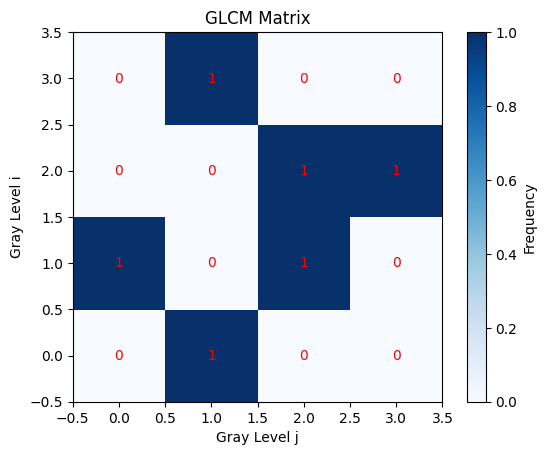

In [38]:
import numpy as np
import matplotlib.pyplot as plt


# Plot the GLCM matrix
plt.imshow(glcm[:, :, 0, 0], cmap='Blues', origin='lower')

# Annotate each cell with the frequency value
for i in range(glcm.shape[0]):
    for j in range(glcm.shape[1]):
        plt.text(j, i, str(glcm[i, j, 0, 0]), ha='center', va='center', color='red')

plt.title('GLCM Matrix')
plt.xlabel('Gray Level j')
plt.ylabel('Gray Level i')
plt.colorbar(label='Frequency')
plt.show()


In [39]:
np.pi / 4

0.7853981633974483